Discentes: Romeu Miranda Borges e João Pedro Noronha de M. Souza

Link para a base de dados: https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings

# Ignorar warnings para melhor visualização do notebook
warnings.filterwarnings('ignore')

# Configurações para gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

In [17]:
# Caminho para o arquivo CSV
file_path = '../data/personality_dataset.csv'

try:
    df = pd.read_csv(file_path)
    print("Dados coletados com sucesso!")
    print(f"Número de linhas: {df.shape[0]}, Número de colunas: {df.shape[1]}")
    print("\nPrimeiras 5 linhas do dataset:")
    print(df.head())
except FileNotFoundError:
    print(f"Erro: O arquivo '{file_path}' não foi encontrado. Certifique-se de que o caminho está correto.")
    df = None # Definir df como None para evitar erros posteriores se o arquivo não for encontrado

Dados coletados com sucesso!
Número de linhas: 2900, Número de colunas: 8

Primeiras 5 linhas do dataset:
   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0   
2               9.0        Yes                      1.0            2.0   
3               0.0         No                      6.0            7.0   
4               3.0         No                      9.0            4.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency Personality  
0                        No                 13.0             5.0   Extrovert  
1                       Yes                  0.0             3.0   Introvert  
2                       Yes                  5.0             2.0   Introvert  
3                        No                 14.0             8.0   Extrovert  
4                        No                  8.0      


Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB

Estatísticas descritivas das variáveis numéricas:
       Time_spent_Alone  Social_event_attendance  Going_outside  \
count       2837.000000              2838.000000    2834.000000   
mean           4.505816                 3.963354       3.000000   
std

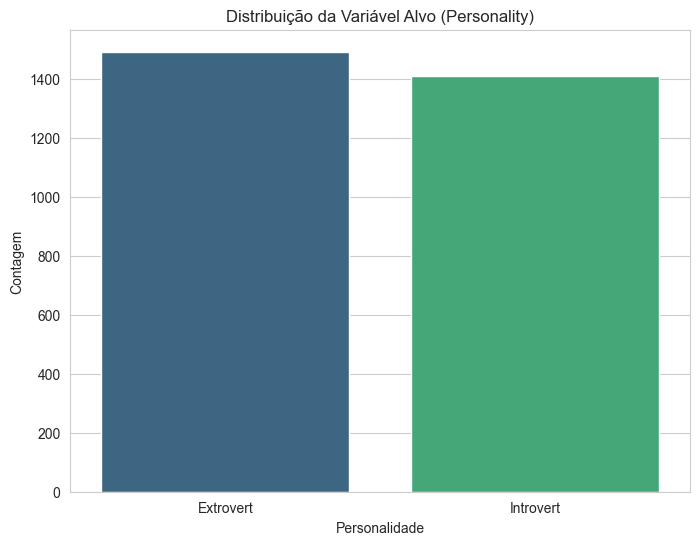


### Análise Gráfica ###


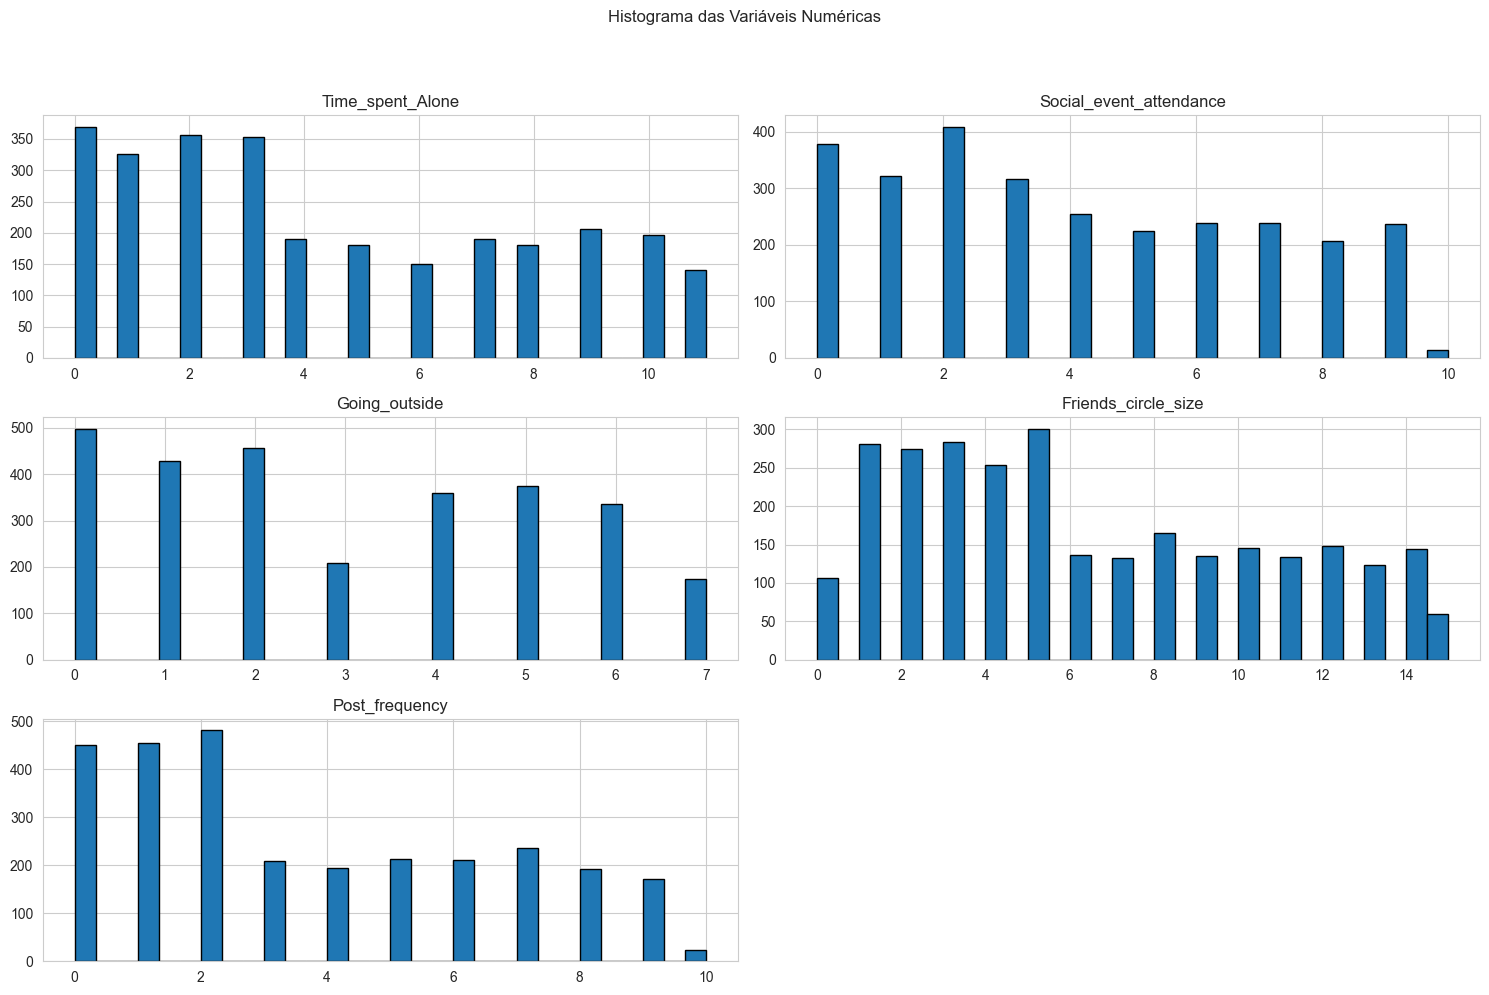

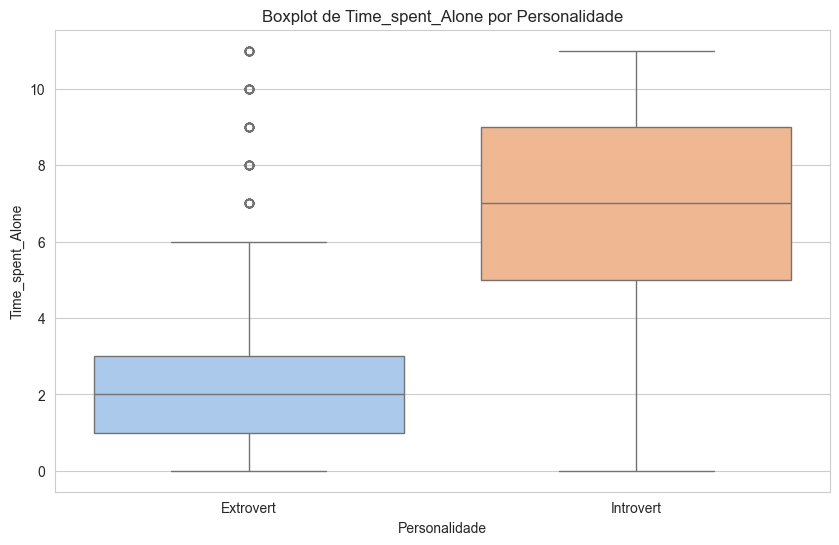

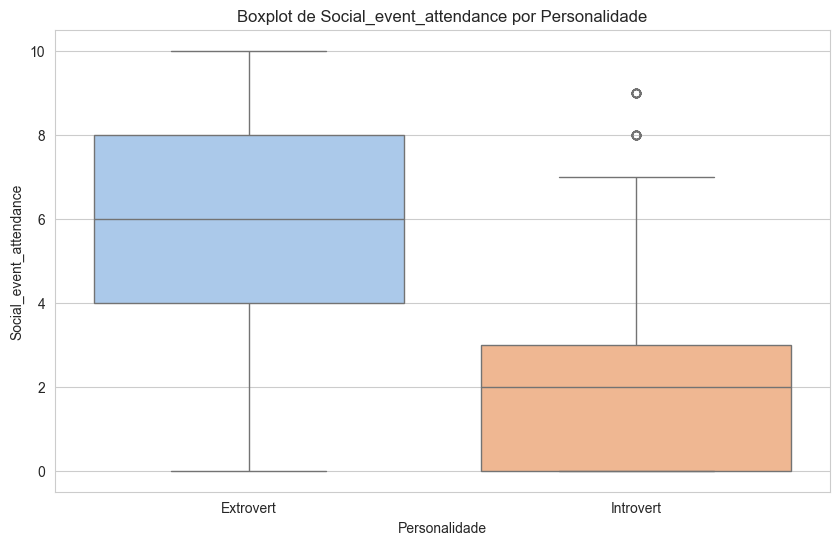

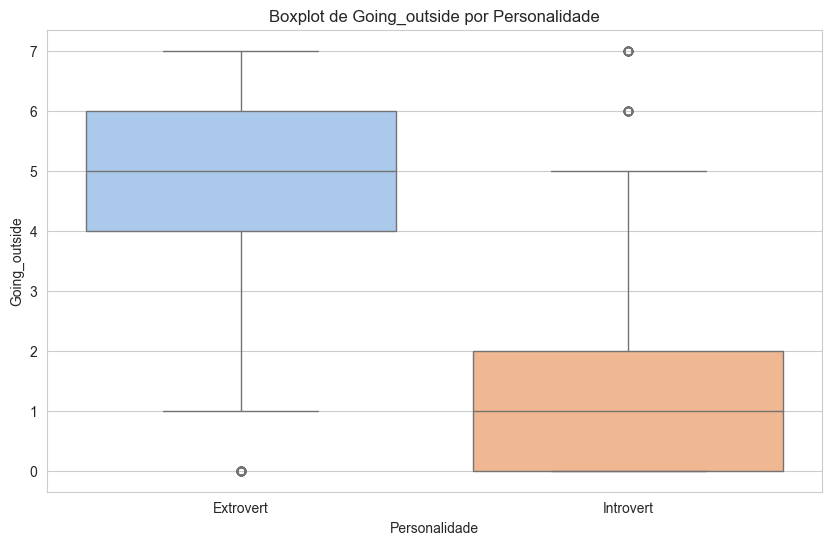

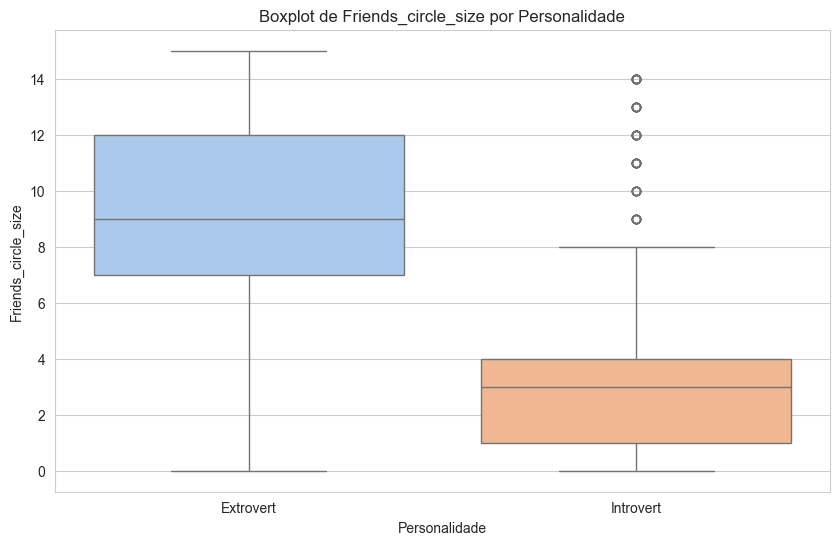

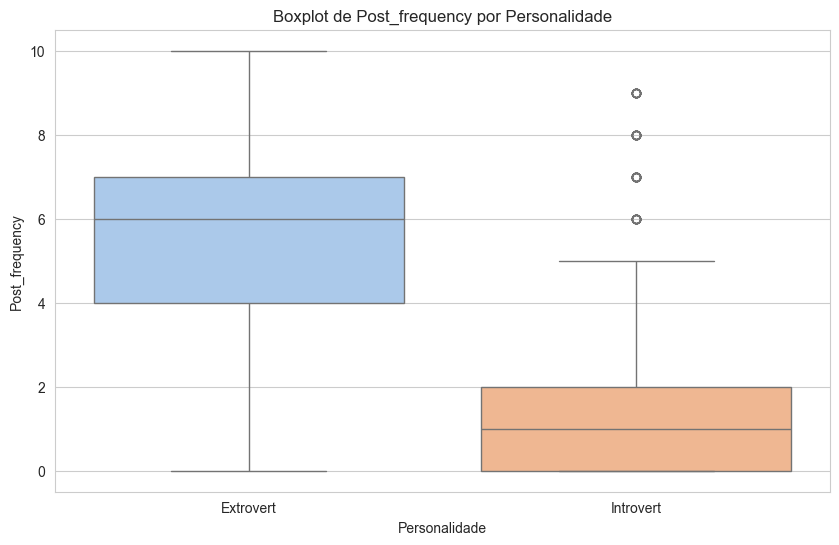

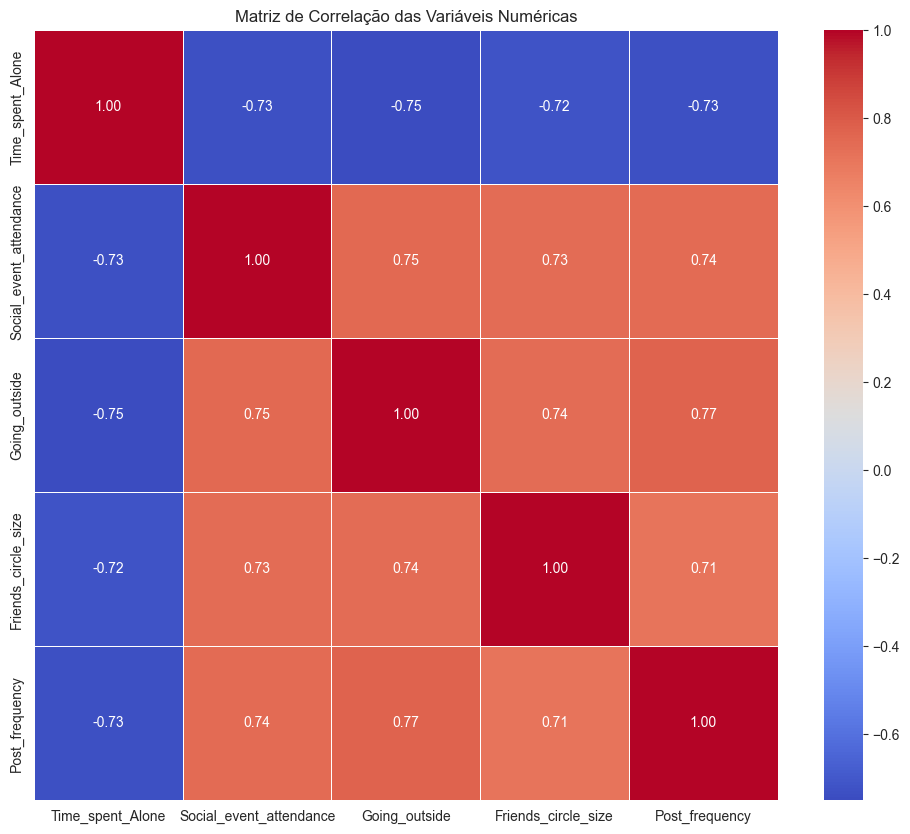

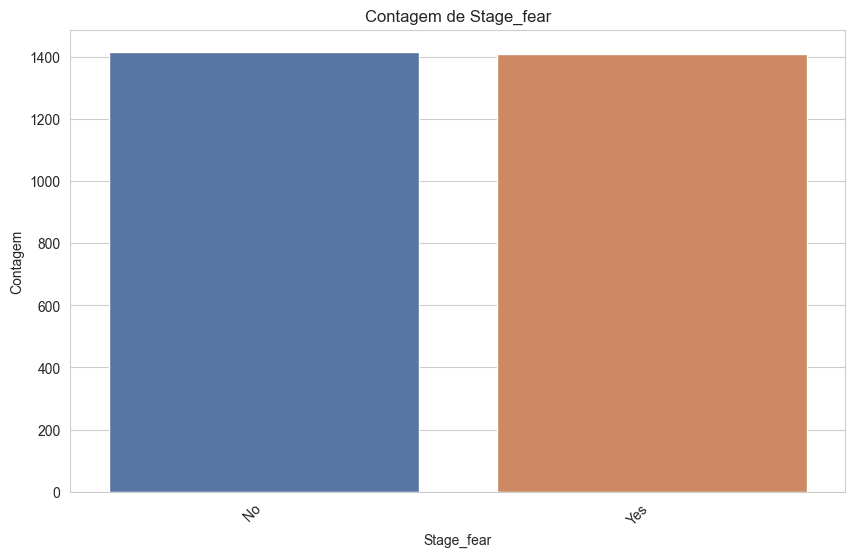

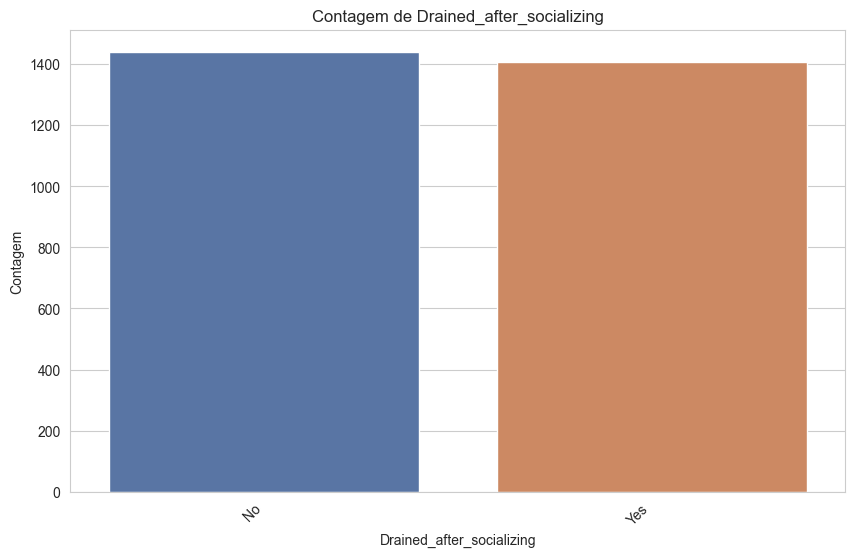

In [18]:
if df is not None:
    print("\nInformações do dataset:")
    df.info()

    print("\nEstatísticas descritivas das variáveis numéricas:")
    print(df.describe())

    print("\nContagem de valores únicos para cada coluna:")
    for column in df.columns:
        print(f"{column}: {df[column].nunique()} valores únicos")

    # Verificar a distribuição da variável alvo
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Personality', data=df, palette='viridis')
    plt.title('Distribuição da Variável Alvo (Personality)')
    plt.xlabel('Personalidade')
    plt.ylabel('Contagem')
    plt.show()

    print("\n### Análise Gráfica ###")

    # Gráfico 1: Histograma das variáveis numéricas
    # Este gráfico mostra a distribuição de cada variável numérica, ajudando a identificar assimetrias,
    # picos múltiplos ou outras formas de distribuição que podem influenciar a escolha de transformações.
    numeric_cols = df.select_dtypes(include=np.number).columns
    if not numeric_cols.empty:
        df[numeric_cols].hist(bins=30, figsize=(15, 10), edgecolor='black')
        plt.suptitle('Histograma das Variáveis Numéricas', y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.show()
    else:
        print("Não há colunas numéricas para plotar histogramas.")


    # Gráfico 2: Boxplot para identificar outliers por categoria de personalidade
    # Os boxplots são excelentes para visualizar a distribuição de uma variável numérica em relação
    # a uma variável categórica, além de evidenciar a presença de outliers (pontos fora dos "bigodes").
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Personality', y=col, data=df, palette='pastel')
        plt.title(f'Boxplot de {col} por Personalidade')
        plt.xlabel('Personalidade')
        plt.ylabel(col)
        plt.show()

    # Gráfico 3: Matriz de Correlação
    # A matriz de correlação visualiza as relações lineares entre todas as variáveis numéricas.
    # Cores mais escuras ou claras (dependendo do mapa de cores) indicam correlações mais fortes,
    # sejam elas positivas ou negativas. Ajuda a identificar multicolinearidade entre features.
    if not numeric_cols.empty:
        plt.figure(figsize=(12, 10))
        sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Matriz de Correlação das Variáveis Numéricas')
        plt.show()
    else:
        print("Não há colunas numéricas para plotar a matriz de correlação.")

    # Gráfico 4: Countplot para variáveis categóricas (se houver)
    # Mostra a contagem de ocorrências para cada categoria de uma variável categórica.
    # Útil para entender a distribuição e balanceamento das categorias.
    categorical_cols = df.select_dtypes(include='object').columns
    if 'Personality' in categorical_cols:
        categorical_cols = categorical_cols.drop('Personality') # Remover a variável alvo

    if not categorical_cols.empty:
        for col in categorical_cols:
            plt.figure(figsize=(10, 6))
            sns.countplot(x=col, data=df, palette='deep', order=df[col].value_counts().index)
            plt.title(f'Contagem de {col}')
            plt.xlabel(col)
            plt.ylabel('Contagem')
            plt.xticks(rotation=45, ha='right')
            plt.show()
    else:
        print("Não há colunas categóricas para plotar countplots.")

In [19]:
if df is not None:
    print("\nValores ausentes antes da limpeza:")
    print(df.isnull().sum())

    # Separação das colunas numéricas e categóricas
    numeric_features = df.select_dtypes(include=np.number).columns
    categorical_features = df.select_dtypes(include='object').columns.drop('Personality', errors='ignore') # Ignorar 'Personality'

    # Criação dos imputers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')) # Mediana para numéricas
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')) # Moda para categóricas
    ])

    # Preprocessor para aplicar transformações diferentes a colunas diferentes
    preprocessor_impute = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Manter outras colunas não especificadas
    )

    # Aplicar a imputação
    # Nota: para manter o nome das colunas e o formato do DataFrame, é mais complexo
    # Em um pipeline final com o ColumnTransformer, os nomes das colunas são alterados.
    # Para EDA após imputação, faremos manualmente aqui.
    for col in numeric_features:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Valores ausentes na coluna '{col}' preenchidos com a mediana ({median_val}).")

    for col in categorical_features:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Valores ausentes na coluna '{col}' preenchidos com a moda ('{mode_val}').")


    print("\nValores ausentes após a limpeza:")
    print(df.isnull().sum().sum()) # Deve ser 0 se tudo foi tratado

    # Verificação de duplicatas
    print(f"\nNúmero de linhas duplicadas antes da remoção: {df.duplicated().sum()}")
    df.drop_duplicates(inplace=True)
    print(f"Número de linhas duplicadas após a remoção: {df.duplicated().sum()}")
    print(f"Número de linhas após a remoção de duplicatas: {df.shape[0]}")
else:
    print("DataFrame não carregado, pulando a limpeza de dados.")


Valores ausentes antes da limpeza:
Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
Personality                   0
dtype: int64
Valores ausentes na coluna 'Time_spent_Alone' preenchidos com a mediana (4.0).
Valores ausentes na coluna 'Social_event_attendance' preenchidos com a mediana (3.0).
Valores ausentes na coluna 'Going_outside' preenchidos com a mediana (3.0).
Valores ausentes na coluna 'Friends_circle_size' preenchidos com a mediana (5.0).
Valores ausentes na coluna 'Post_frequency' preenchidos com a mediana (3.0).
Valores ausentes na coluna 'Stage_fear' preenchidos com a moda ('No').
Valores ausentes na coluna 'Drained_after_socializing' preenchidos com a moda ('No').

Valores ausentes após a limpeza:
0

Número de linhas duplicadas antes da remoção: 448
Número de linhas duplicadas após a remoção: 0
Númer

In [20]:
if df is not None:
    print("\n### Análise e Identificação de Outliers ###")
    def cap_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series.clip(lower=lower_bound, upper=upper_bound)

    for col in numeric_cols:
        df[col] = cap_outliers(df[col])
    print("\nOutliers tratados por capping.")
else:
    print("DataFrame não carregado, pulando o tratamento de outliers.")


### Análise e Identificação de Outliers ###

Outliers tratados por capping.


In [21]:
if df is not None:
    # Separar features (X) e target (y)
    X = df.drop('Personality', axis=1)
    y = df['Personality']

    # Identificar colunas numéricas e categóricas para o preprocessor
    numeric_features = X.select_dtypes(include=np.number).columns
    categorical_features = X.select_dtypes(include='object').columns

    print(f"\nVariáveis categóricas identificadas para codificação: {list(categorical_features)}")

    # Preprocessor para imputação e codificação
    # Criamos um novo preprocessor para o pipeline de ML, que inclui a codificação.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numeric_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ],
        remainder='passthrough'
    )
    print("\nPreprocessor para codificação criado com sucesso!")
else:
    print("DataFrame não carregado, pulando a codificação de variáveis categóricas.")


Variáveis categóricas identificadas para codificação: ['Stage_fear', 'Drained_after_socializing']

Preprocessor para codificação criado com sucesso!


In [22]:
if df is not None:
    print("\nVerificando o balanceamento de classes:")
    print(y.value_counts())

    # Se a classe 'introvert' ou 'extrovert' for significativamente menor, aplicamos SMOTE.
    # Definimos um limiar, por exemplo, se a classe minoritária for menos de 40% da majoritária.
    class_counts = y.value_counts()
    if len(class_counts) > 1: # Verifica se há mais de uma classe
        minority_class_count = class_counts.min()
        majority_class_count = class_counts.max()

        if minority_class_count / majority_class_count < 0.8: # Limiar de 80% para considerar desbalanceado
            print("\nClasses desbalanceadas detectadas. Será aplicado SMOTE durante o treinamento.")
            balance_needed = True
        else:
            print("\nClasses parecem balanceadas ou o desbalanceamento não é significativo.")
            balance_needed = False
    else:
        print("\nApenas uma classe presente na variável alvo. O balanceamento de classes não é aplicável.")
        balance_needed = False
else:
    print("DataFrame não carregado, pulando a verificação de balanceamento de classes.")
    balance_needed = False


Verificando o balanceamento de classes:
Personality
Extrovert    1395
Introvert    1057
Name: count, dtype: int64

Classes desbalanceadas detectadas. Será aplicado SMOTE durante o treinamento.


In [23]:
if df is not None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify para manter a proporção das classes
    print(f"\nDados divididos em treino ({X_train.shape[0]} amostras) e teste ({X_test.shape[0]} amostras).")
    print(f"Proporção da classe 'Extrovert' no treino: {y_train.value_counts(normalize=True)['Extrovert']:.2f}")
    print(f"Proporção da classe 'Extrovert' no teste: {y_test.value_counts(normalize=True)['Extrovert']:.2f}")
else:
    print("DataFrame não carregado, pulando a divisão dos dados.")


Dados divididos em treino (1961 amostras) e teste (491 amostras).
Proporção da classe 'Extrovert' no treino: 0.57
Proporção da classe 'Extrovert' no teste: 0.57


In [24]:
if df is not None:
    # O pipeline completo com preprocessor, escalonador e modelo
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)), # with_mean=False se houver sparse matrix após one-hot encoding
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    if balance_needed:
        # Se for necessário balancear, criamos um pipeline que inclui SMOTE
        from imblearn.pipeline import Pipeline as ImbPipeline
        model_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler(with_mean=False)),
            ('smote', SMOTE(random_state=42)),
            ('classifier', RandomForestClassifier(random_state=42))
        ])
        print("Pipeline com SMOTE configurado.")

    print("\nIniciando o treinamento do modelo...")
    model_pipeline.fit(X_train, y_train)
    print("Modelo treinado com sucesso!")
else:
    print("DataFrame não carregado, pulando o treinamento do modelo.")

Pipeline com SMOTE configurado.

Iniciando o treinamento do modelo...
Modelo treinado com sucesso!



### Avaliação do Modelo ###

Relatório de Classificação:
              precision    recall  f1-score   support

   Extrovert       0.90      0.92      0.91       279
   Introvert       0.89      0.87      0.88       212

    accuracy                           0.90       491
   macro avg       0.90      0.90      0.90       491
weighted avg       0.90      0.90      0.90       491



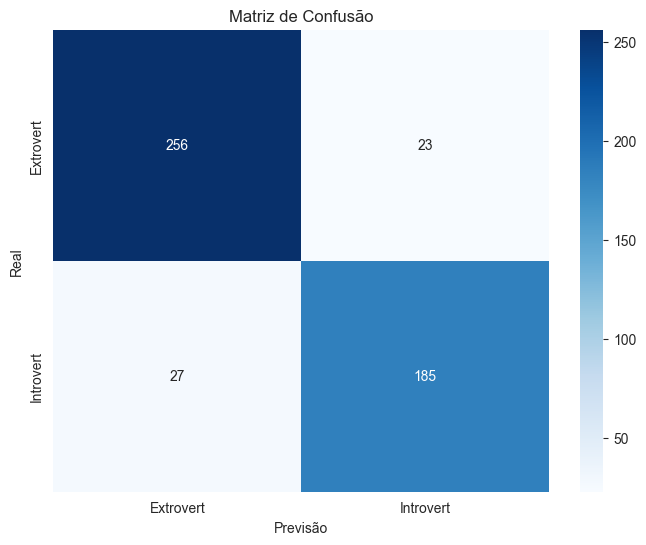


**Interpretação da Matriz de Confusão:**
  - A diagonal principal mostra as previsões corretas (Verdadeiros Positivos e Verdadeiros Negativos).
  - Os outros valores representam os erros (Falsos Positivos e Falsos Negativos).
  - Idealmente, os valores fora da diagonal principal devem ser baixos.


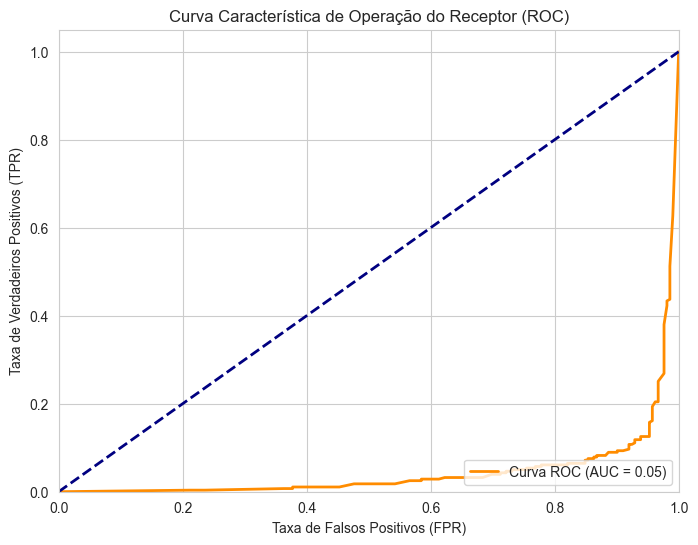


**Interpretação da Curva ROC e AUC:**
  - A Curva ROC ilustra o desempenho de um modelo de classificação em todos os limites de classificação.
  - O eixo X é a Taxa de Falsos Positivos (FPR) e o eixo Y é a Taxa de Verdadeiros Positivos (TPR).
  - A Área Sob a Curva (AUC) mede a capacidade do modelo de distinguir entre classes. Uma AUC próxima de 1 indica um modelo excelente, enquanto 0.5 sugere um desempenho aleatório.

Realizando Validação Cruzada (5-fold):
Scores de Validação Cruzada (Acurácia): [0.92057026 0.90020367 0.89591837 0.88367347 0.87755102]
Média da Acurácia de Validação Cruzada: 0.8956
Desvio Padrão da Acurácia de Validação Cruzada: 0.0149

**Interpretação da Validação Cruzada:**
  - A Validação Cruzada fornece uma estimativa mais robusta do desempenho do modelo, pois treina e avalia o modelo em diferentes subconjuntos dos dados.
  - Uma média alta e um desvio padrão baixo nos scores indicam um modelo mais estável e generalizável.


In [25]:
if df is not None:
    print("\n### Avaliação do Modelo ###")
    y_pred = model_pipeline.predict(X_test)
    y_prob = model_pipeline.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (Extrovert)

    # Relatório de Classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model_pipeline.named_steps['classifier'].classes_,
                yticklabels=model_pipeline.named_steps['classifier'].classes_)
    plt.title('Matriz de Confusão')
    plt.xlabel('Previsão')
    plt.ylabel('Real')
    plt.show()
    print("\n**Interpretação da Matriz de Confusão:**")
    print("  - A diagonal principal mostra as previsões corretas (Verdadeiros Positivos e Verdadeiros Negativos).")
    print("  - Os outros valores representam os erros (Falsos Positivos e Falsos Negativos).")
    print("  - Idealmente, os valores fora da diagonal principal devem ser baixos.")

    # Curva ROC e AUC
    # Para a Curva ROC, precisamos das classes binárias. Assumindo 'Extrovert' como a classe positiva (1).
    # Mapear 'Extrovert' para 1 e 'Introvert' para 0
    y_test_binary = (y_test == 'Extrovert').astype(int)

    fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Curva Característica de Operação do Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    print("\n**Interpretação da Curva ROC e AUC:**")
    print("  - A Curva ROC ilustra o desempenho de um modelo de classificação em todos os limites de classificação.")
    print("  - O eixo X é a Taxa de Falsos Positivos (FPR) e o eixo Y é a Taxa de Verdadeiros Positivos (TPR).")
    print("  - A Área Sob a Curva (AUC) mede a capacidade do modelo de distinguir entre classes. Uma AUC próxima de 1 indica um modelo excelente, enquanto 0.5 sugere um desempenho aleatório.")

    # Validação Cruzada (Cross-validation)
    print("\nRealizando Validação Cruzada (5-fold):")
    # Para cross_val_score, precisamos do preprocessor e scaler aplicados diretamente ou dentro do pipeline
    # O pipeline já cuida disso.
    cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1)
    print(f"Scores de Validação Cruzada (Acurácia): {cv_scores}")
    print(f"Média da Acurácia de Validação Cruzada: {cv_scores.mean():.4f}")
    print(f"Desvio Padrão da Acurácia de Validação Cruzada: {cv_scores.std():.4f}")
    print("\n**Interpretação da Validação Cruzada:**")
    print("  - A Validação Cruzada fornece uma estimativa mais robusta do desempenho do modelo, pois treina e avalia o modelo em diferentes subconjuntos dos dados.")
    print("  - Uma média alta e um desvio padrão baixo nos scores indicam um modelo mais estável e generalizável.")
else:
    print("DataFrame não carregado, pulando a avaliação do modelo.")

In [26]:
if df is not None:
    print("\n### Ajuste de Hiperparâmetros com GridSearchCV ###")
    # Definir o espaço de busca para os hiperparâmetros
    param_grid = {
        'classifier__n_estimators': [100, 200, 300], # Número de árvores na floresta
        'classifier__max_depth': [10, 20, None], # Profundidade máxima da árvore
        'classifier__min_samples_split': [2, 5, 10] # Número mínimo de amostras para dividir um nó
    }

    # Se estiver usando SMOTE no pipeline, os parâmetros devem ser prefixados com 'classifier__'
    # No entanto, se o SMOTE estiver ativo, os nomes dos passos mudam para o ImbPipeline.
    # O ImbPipeline é compatível com os prefixos como um Pipeline normal.

    grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

    print("Iniciando o GridSearchCV...")
    grid_search.fit(X_train, y_train)

    print("\nMelhores hiperparâmetros encontrados:")
    print(grid_search.best_params_)

    print("\nMelhor score de validação (treino) com os melhores parâmetros:")
    print(grid_search.best_score_)

    best_model = grid_search.best_estimator_
    print("\nMelhor modelo treinado com os melhores parâmetros.")
else:
    print("DataFrame não carregado, pulando o ajuste de hiperparâmetros.")


### Ajuste de Hiperparâmetros com GridSearchCV ###
Iniciando o GridSearchCV...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Melhores hiperparâmetros encontrados:
{'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}

Melhor score de validação (treino) com os melhores parâmetros:
0.9235099353255499

Melhor modelo treinado com os melhores parâmetros.



### Testes Finais e Validação com o Melhor Modelo ###

Relatório de Classificação Final:
              precision    recall  f1-score   support

   Extrovert       0.94      0.94      0.94       279
   Introvert       0.92      0.92      0.92       212

    accuracy                           0.93       491
   macro avg       0.93      0.93      0.93       491
weighted avg       0.93      0.93      0.93       491



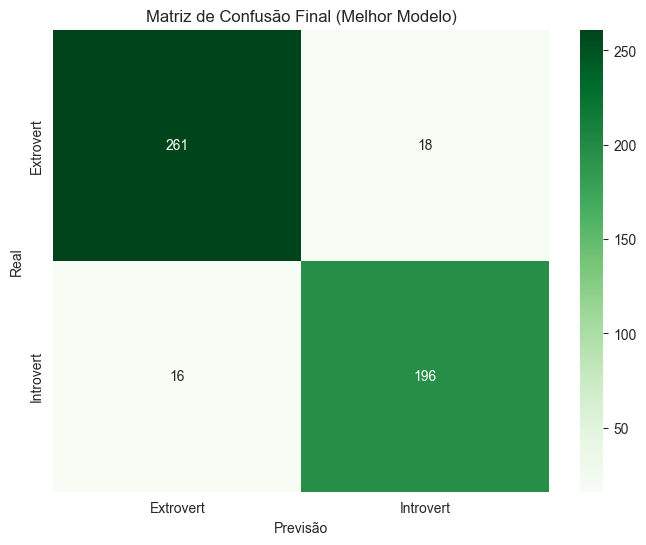

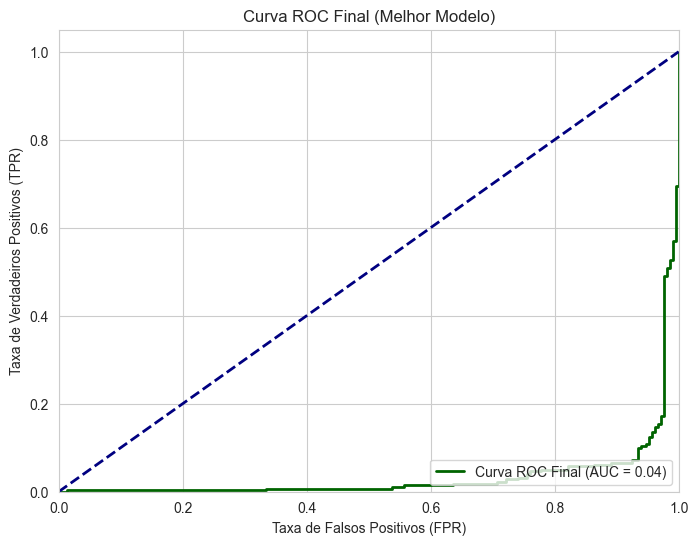


Conclusão: O pipeline foi executado com sucesso, desde a coleta de dados até a validação final do modelo. As métricas de avaliação fornecem insights sobre o desempenho do modelo na classificação de personalidades.
Você pode agora usar o 'best_model' para fazer previsões em novos dados.


In [27]:
if df is not None and 'best_model' in locals():
    print("\n### Testes Finais e Validação com o Melhor Modelo ###")
    y_pred_final = best_model.predict(X_test)
    y_prob_final = best_model.predict_proba(X_test)[:, 1]

    print("\nRelatório de Classificação Final:")
    print(classification_report(y_test, y_pred_final))

    cm_final = confusion_matrix(y_test, y_pred_final)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens',
                xticklabels=best_model.named_steps['classifier'].classes_,
                yticklabels=best_model.named_steps['classifier'].classes_)
    plt.title('Matriz de Confusão Final (Melhor Modelo)')
    plt.xlabel('Previsão')
    plt.ylabel('Real')
    plt.show()

    # Curva ROC final
    y_test_binary = (y_test == 'Extrovert').astype(int)
    fpr_final, tpr_final, thresholds_final = roc_curve(y_test_binary, y_prob_final)
    roc_auc_final = auc(fpr_final, tpr_final)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_final, tpr_final, color='darkgreen', lw=2, label=f'Curva ROC Final (AUC = {roc_auc_final:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Curva ROC Final (Melhor Modelo)')
    plt.legend(loc="lower right")
    plt.show()

    print("\nConclusão: O pipeline foi executado com sucesso, desde a coleta de dados até a validação final do modelo. As métricas de avaliação fornecem insights sobre o desempenho do modelo na classificação de personalidades.")
    print("Você pode agora usar o 'best_model' para fazer previsões em novos dados.")
else:
    print("DataFrame não carregado ou melhor modelo não encontrado, pulando testes finais.")